# Integrated Model

In this notebook, we build an integrated model where we combine the BERT tokens along with the poster feature vectors. 

Within the notebook, there is also code to oversample the data and we test our model, both on the no-oversampled and oversampled dataset. 

Further, we use custom loss and accuracy functions which are defined below in the notebook.

### Load Modules <a id="load" />


In [0]:
!pip install tensorflow==2.1.0

     |████████████████████████████████| 421.8MB 30kB/s 
     |████████████████████████████████| 3.9MB 51.9MB/s 
     |████████████████████████████████| 450kB 62.2MB/s 
  Created wheel for gast: filename=gast-0.2.2-cp36-none-any.whl size=7540 sha256=4f76f199367c3b8193d94f06dcf9c11f3d0b854b932d612f50af75ae7a014523
  Stored in directory: /root/.cache/pip/wheels/5c/2e/7e/a1d4d4fcebe6c381f378ce7743a3ced3699feb89bcfbdadadd
Successfully built gast
  Found existing installation: gast 0.3.3
    Uninstalling gast-0.3.3:
      Successfully uninstalled gast-0.3.3
  Found existing installation: tensorboard 2.2.0
    Uninstalling tensorboard-2.2.0:
      Successfully uninstalled tensorboard-2.2.0
  Found existing installation: tensorflow-estimator 2.2.0rc0
    Uninstalling tensorflow-estimator-2.2.0rc0:
      Successfully uninstalled tensorflow-estimator-2.2.0rc0
  Found existing installation: tensorflow 2.2.0rc2
    Uninstalling tensorflow-2.2.0rc2:
      Successfully uninstalled tensorflow-2.2.0rc

In [0]:
import tensorflow as tf
print(tf.__version__)

2.1.0


In [0]:
# Imports

import json
import pandas as pd
import numpy as np
import os
import sys
import tensorflow as tf
import tensorflow_hub as hub
from time import time
import io
import re
from csv import reader
from datetime import datetime
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.ticker import PercentFormatter

from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.python.keras.layers import Lambda
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.backend import sparse_categorical_crossentropy
from tensorflow.keras.layers import Dense, TimeDistributed

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import keras.backend.tensorflow_backend as tfb

from tensorflow.keras.mixed_precision import experimental as mixed_precision
from keras import initializers

Using TensorFlow backend.


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
# Define maximal length of input 'sentences' (post tokenization).
max_length = 128

# ERROR TEST
ERROR_TEST = 0

# OS / NoOS
OVERSAMPLING = True

In [0]:
if (ERROR_TEST):
    NUM_LABELS = 1
    OVERSAMPLING = False
    
    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/baseline_test/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline_test/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/plots/baseline_test/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'
else:
    NUM_LABELS = 10

    data_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/baseline/'
    model_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/model/baseline/'
    plot_save_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/plots/baseline/'
    data_load_prefix = '/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/data/'


### Loading the data

In [0]:
X_train = np.load(data_load_prefix + 'clean_train_bert_tokens_' + str(max_length) + '.data.npy')
X_dev = np.load(data_load_prefix + 'clean_dev_bert_tokens_'  + str(max_length) + '.data.npy')
X_val = np.load(data_load_prefix + 'clean_val_bert_tokens_'  + str(max_length) + '.data.npy')

y_train = np.load(data_load_prefix + 'clean_train_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_dev = np.load(data_load_prefix + 'clean_dev_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)
y_val = np.load(data_load_prefix + 'clean_val_poster_labels_' + str(NUM_LABELS) + '.data.npy', allow_pickle=True)

posterVectors_train = np.load(data_load_prefix + 'clean_train_poster_vectors.data.npy', allow_pickle=True)
posterVectors_dev = np.load(data_load_prefix+ 'clean_dev_poster_vectors.data.npy', allow_pickle=True)
posterVectors_val = np.load(data_load_prefix+ 'clean_val_poster_vectors.data.npy', allow_pickle=True)

In [0]:
df_train = pd.read_csv(data_load_prefix + 'clean_df_train_labels_' + str(NUM_LABELS) + '.csv')
df_dev = pd.read_csv(data_load_prefix + 'clean_df_dev_labels_' + str(NUM_LABELS) + '.csv')
df_val = pd.read_csv(data_load_prefix + 'clean_df_val_labels_' + str(NUM_LABELS) + '.csv')

In [0]:
def oversample_keeping_original(X, y, poster_X, bottom_n = 6, count_per_category = 5000):
    genre_counts = np.sum(y,axis = 0)
    genre_sorted_index = np.argsort(genre_counts)[:bottom_n]
    np.random.seed(0)
    
    new_y = np.array([])
    new_X = np.array([])
    new_poster_X = np.array([])
    list_samples = np.array([])
    for index,i in enumerate(genre_sorted_index):
        indices = np.where(y[:,i]>0)
        samples = np.random.choice(indices[0],count_per_category)
        # print(i,samples[-20:])
        if index==0:
            new_y = np.concatenate((y, y[samples,:]), axis = 0)
            new_X = np.concatenate((X, X[:,samples,:]), axis = 1)
            new_poster_X = np.concatenate((poster_X, poster_X[samples,:]), axis = 0)
            print("index 0 ", np.arange(X.shape[1]))
            list_samples = np.concatenate((np.arange(X.shape[1]) ,samples), axis = 0)
        else:
            new_y = np.concatenate((new_y, y[samples,:]), axis=0)
            new_X = np.concatenate((new_X, X[:,samples,:]),axis=1)
            new_poster_X = np.concatenate((new_poster_X, poster_X[samples,:]), axis = 0)
            list_samples = np.concatenate((list_samples, samples), axis=0)

    indexArray = np.arange(0, new_y.shape[0], 1, dtype=np.int32)
    print("Len of index array is ", len(indexArray))

    np.random.seed(0)
    np.random.shuffle(indexArray)

    return (new_X[:,indexArray,:], new_y[indexArray], new_poster_X[indexArray],list_samples[indexArray])

In [0]:
if (OVERSAMPLING):
    new_X_train, new_y_train, new_posterVectors_train, list_samples = oversample_keeping_original(X_train, y_train, posterVectors_train, bottom_n = 6, count_per_category = 5000)
    new_df_train = df_train.iloc[list_samples]
    
    print(np.sum(y_train,axis = 0)/y_train.shape[0])
    print(np.sum(new_y_train,axis = 0)/new_y_train.shape[0])
    
    print(new_X_train.shape)
    print(new_y_train.shape)
    print(new_posterVectors_train.shape)
    print(len(list_samples))

index 0  [    0     1     2 ... 46967 46968 46969]
Len of index array is  76970
[0.55465191 0.19650841 0.34430488 0.15190547 0.13385139 0.11807537
 0.19759421 0.08909943 0.07404726 0.06086864]
[0.48726777 0.27334026 0.29650513 0.24108094 0.19822009 0.19175003
 0.16266078 0.16438872 0.14905807 0.14058724]
(3, 76970, 128)
(76970, 10)
(76970, 2048)
76970


### Custom Loss and Accuracy Functions

In [0]:
#@tf.function
def macro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y, axis=0), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y), axis=0), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y, axis=0), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    macro_f1 = tf.reduce_mean(f1)
    return macro_f1

#@tf.function
def micro_f1(y, y_hat, thresh=0.5):
    """Compute the macro F1-score on a batch of observations (average F1 across labels)
    
    Args:
        y (int32 Tensor): labels array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        thresh: probability value above which we predict positive
        
    Returns:
        macro_f1 (scalar Tensor): value of macro F1 for the batch
    """
    y_pred = tf.cast(tf.greater(y_hat, thresh), tf.float32)
    tp = tf.cast(tf.math.count_nonzero(y_pred * y), tf.float32)
    fp = tf.cast(tf.math.count_nonzero(y_pred * (1 - y)), tf.float32)
    fn = tf.cast(tf.math.count_nonzero((1 - y_pred) * y), tf.float32)
    f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    micro_f1 = f1 #tf.reduce_mean(f1)
    return micro_f1

#@tf.function
def macro_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
        
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    soft_f1 = 2*tp / (2*tp + fn + fp + 1e-16)
    cost = 1 - soft_f1 # reduce 1 - soft-f1 in order to increase soft-f1
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

POS_WEIGHT = 10
#@tf.function
def weighted_binary_crossentropy(y, y_hat):
    """
    Weighted binary crossentropy between an output tensor 
    and a target tensor. POS_WEIGHT is used as a multiplier 
    for the positive targets.

    Combination of the following functions:
    * keras.losses.binary_crossentropy
    * keras.backend.tensorflow_backend.binary_crossentropy
    * tf.nn.weighted_cross_entropy_with_logits
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # transform back to logits
    _epsilon = tfb._to_tensor(tfb.epsilon(), y_hat.dtype.base_dtype)
    y_hat = tf.clip_by_value(y_hat, _epsilon, 1 - _epsilon)
    y_hat = tf.math.log(y_hat / (1 - y_hat))
    # compute weighted loss
    loss = tf.nn.weighted_cross_entropy_with_logits(labels=y,
                                                    logits=y_hat,
                                                    pos_weight=POS_WEIGHT)
    return tf.reduce_mean(loss, axis=-1)

#@tf.function
def binary_crossentropy(y, y_hat):
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    # compute loss
    loss = tf.keras.backend.binary_crossentropy(y, y_hat, from_logits=True)
    return tf.reduce_mean(loss, axis=-1)

#@tf.function
def macro_double_soft_f1(y, y_hat):
    """Compute the macro soft F1-score as a cost (average 1 - soft-F1 across all labels).
    Use probability values instead of binary predictions.
    This version uses the computation of soft-F1 for both positive and negative class for each label.
    Args:
        y (int32 Tensor): targets array of shape (BATCH_SIZE, N_LABELS)
        y_hat (float32 Tensor): probability matrix from forward propagation of shape (BATCH_SIZE, N_LABELS)
    Returns:
        cost (scalar Tensor): value of the cost function for the batch
    """
    y = tf.cast(y, tf.float32)
    y_hat = tf.cast(y_hat, tf.float32)
    tp = tf.reduce_sum(y_hat * y, axis=0)
    fp = tf.reduce_sum(y_hat * (1 - y), axis=0)
    fn = tf.reduce_sum((1 - y_hat) * y, axis=0)
    tn = tf.reduce_sum((1 - y_hat) * (1 - y), axis=0)
    soft_f1_class1 = 2*tp / (2*tp + fn + fp + 1e-16)
    soft_f1_class0 = 2*tn / (2*tn + fn + fp + 1e-16)
    cost_class1 = 1 - soft_f1_class1 # reduce 1 - soft-f1_class1 in order to increase soft-f1 on class 1
    cost_class0 = 1 - soft_f1_class0 # reduce 1 - soft-f1_class0 in order to increase soft-f1 on class 0
    cost = 0.5 * (cost_class1 + cost_class0) # take into account both class 1 and class 0
    macro_cost = tf.reduce_mean(cost) # average on all labels
    return macro_cost

### Model Params

In [0]:
optimizer_select = 'ADAM'
BATCH_SIZE = 128*8
EPOCHS = 30
LR = 1e-4
LOSS = 'macro_double_soft_f1'#'bce'
ACC = ['accuracy',macro_f1,micro_f1]
TRAIN_BERT = True

In [0]:
if OVERSAMPLING:
    NUM_TRAIN_SAMPLES = int(np.floor(new_X_train.shape[1] / BATCH_SIZE) * BATCH_SIZE)
else:
    NUM_TRAIN_SAMPLES = int(np.floor(X_train.shape[1] / BATCH_SIZE) * BATCH_SIZE)

NUM_DEV_SAMPLES = int(np.floor(X_dev.shape[1] / BATCH_SIZE) * BATCH_SIZE)
NUM_VAL_SAMPLES = int(np.floor(X_val.shape[1] / BATCH_SIZE) * BATCH_SIZE)

# NUM_TRAIN_SAMPLES = 25600
# NUM_DEV_SAMPLES = 5120
# NUM_VAL_SAMPLES = 5120

TRAIN_BERT = True
if (TRAIN_BERT):
    if (OVERSAMPLING):
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS)
    else:
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoOS'
else:
    if (OVERSAMPLING):
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoFT'
    else:
        results_prefix = 'baseline_seqlen_' + str(max_length) + '_' + optimizer_select + '_EPOCHS_' + str(EPOCHS) + '_LR_' + str(LR) + '_LOSS_' + str(LOSS) + '_NoFT' + '_NoOS'


In [0]:
def filter_data(X, y, poster, n_size, reverse=False):
    if (reverse):
        X_out = [X[0][-n_size:].astype('int32'), X[1][-n_size:].astype('int32'),X[2][-n_size:].astype('int32'), poster[-n_size:].astype('float32')]
        y_out = y[-n_size:].astype('int32')
        poster_out = poster[-n_size:].astype('float32')
    else:
        X_out = [X[0][0:n_size].astype('int32'), X[1][0:n_size].astype('int32'),X[2][0:n_size].astype('int32'), poster[0:n_size].astype('float32')]
        y_out = y[0:n_size].astype('int32')
        poster_out = poster[0:n_size].astype('float32')

    return (X_out, y_out, poster_out)

rev = False

if OVERSAMPLING:
    bert_inputs_train_k, labels_train_k, posterVectors_train_k = filter_data(new_X_train, 
                                                                            new_y_train, 
                                                                            new_posterVectors_train, 
                                                                            NUM_TRAIN_SAMPLES, 
                                                                            reverse=rev)
else:
    bert_inputs_train_k, labels_train_k, posterVectors_train_k = filter_data(X_train, 
                                                                            y_train, 
                                                                            posterVectors_train, 
                                                                            NUM_TRAIN_SAMPLES, 
                                                                            reverse=rev)


bert_inputs_dev_k, labels_dev_k, posterVectors_dev_k = filter_data(X_dev, 
                                                                   y_dev, 
                                                                   posterVectors_dev, 
                                                                   NUM_DEV_SAMPLES, 
                                                                   reverse=rev)

bert_inputs_val_k, labels_val_k, posterVectors_val_k = filter_data(X_val, 
                                                                   y_val, 
                                                                   posterVectors_val, 
                                                                   NUM_VAL_SAMPLES, 
                                                                   reverse=rev)

In [0]:
len(bert_inputs_train_k[0])

76800

In [0]:
print("Number Train Samples ", NUM_TRAIN_SAMPLES)

Number Train Samples  76800


In [0]:
NUM_LABELS

10

### Training Model

In [0]:
if optimizer_select == 'ADAM':
    optimizer = tf.keras.optimizers.Adam(learning_rate=LR, beta_1=0.91, beta_2=0.999, epsilon=None, decay=0.1, name='Adam')
elif optimizer_select == 'ADAMAX':
    optimizer = tf.keras.optimizers.Adamax(learning_rate=LR, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Adamax')
elif optimizer_select == 'ADAGRAD':
    optimizer = tf.keras.optimizers.Adagrad(learning_rate=LR, initial_accumulator_value=0.1, epsilon=1e-07, name='Adagrad')
elif optimizer_select == 'SGD':
    optimizer = tf.keras.optimizers.SGD(learning_rate=LR, momentum=0.9, nesterov=True, name='SGD', clipvalue=0.5)
elif optimizer_select == 'ADADELTA':
    optimizer = tf.keras.optimizers.Adadelta(learning_rate=1.0, rho=0.95)
else:
    raise Exception('Optimizer not available')

if LOSS == 'bce':
    loss = binary_crossentropy
elif LOSS == 'macro_soft_f1':
    loss = macro_soft_f1
elif LOSS == 'macro_double_soft_f1':
    loss = macro_double_soft_f1
else:
    raise Exception('Loss function not implemented...')

#this is for bfloat16 precision
policy = mixed_precision.Policy('mixed_bfloat16')
mixed_precision.set_policy(policy)

outputFolder = model_save_prefix + results_prefix
if not os.path.exists(outputFolder):
    os.makedirs(outputFolder)

filepath = outputFolder + "/model-{epoch:02d}-{macro_f1:.2f}.hdf5"

callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=1e-3,patience=10)]

cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
tf.config.experimental_connect_to_cluster(cluster_resolver)
tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)

# [64] # [64,64,128,256,512]
filter_size = []

# [[3]] # [[3,3,3,3,3]] # [[3,3,3,3,3], [7,7,7,7,7], [13,13,13,13,13]]
kernel_size = []

# [5120] # [5120,5120] # [2048,1024,1024]
dense_layers = [5120]

L2_REGULARIZATION = 0.0001
DROP_OUT = 0.5
DENSE_LAYER_SIZE = 5120

with strategy.scope():
    # Bert Inputs
    input_word_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_word_ids")
    input_mask = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="input_mask")
    segment_ids = tf.keras.layers.Input(shape=(max_length,), dtype=tf.int32, name="segment_ids")

    bert_inputs = [input_word_ids, input_mask, segment_ids]

    bert_layer = hub.KerasLayer("gs://w266-finalproject/bert_models/bert_en_uncased_L-12_H-768_A-12/1", 
                                name='bert',
                                trainable=TRAIN_BERT)
    pooled_output, sequence_output= bert_layer(bert_inputs)
    pooled_output = tf.keras.layers.Dropout(rate=DROP_OUT, name='Dropout_bert_pooled')(pooled_output)

    dense = tf.keras.layers.Dense(5120, 
                                  activation='relu',
                                #  kernel_initializer='random_normal',
                                  kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
                                #   bias_regularizer=tf.keras.regularizers.l1(0.01),
                                  name='Dense_BERT_1'
                                  )(pooled_output)
    dense = tf.keras.layers.Dropout(rate=DROP_OUT, name='Dropout_BERT_1')(dense)

    dense = tf.keras.layers.Dense(5120, 
                                  activation='relu',
                                #  kernel_initializer='random_normal',
                                  kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
                                #   bias_regularizer=tf.keras.regularizers.l1(0.01),
                                  name='Dense_BERT_2'
                                  )(dense)
    dropout_bert_2 = tf.keras.layers.Dropout(rate=DROP_OUT, name='Dropout_BERT_2')(dense)


    # Resnet
    if len(kernel_size) >0 :
        feature_vector = tf.keras.layers.Input(shape=(2048,1),
                                               dtype=np.float32,
                                               name="ResnetFeatureVector")
    else:
        feature_vector = tf.keras.layers.Input(shape=(2048,),
                                               dtype=np.float32, 
                                               name="ResnetFeatureVector")

    batch_norm_list = []
    for j in range(0,len(kernel_size)):
        for i in range(0,len(filter_size)):
            if i==0:
                conv = tf.keras.layers.Conv1D(filters=filter_size[i],
                                              kernel_size=kernel_size[j][i],
                                              input_shape=(2048,),
                                              padding='same',
                                              activation='relu',
                                              strides=1, 
                                              name='Conv_' + str(j)+str(i) + '_KernelSize_'+str(kernel_size[j][i]),
                                              data_format='channels_last')(feature_vector)
            else:
                conv = tf.keras.layers.Conv1D(filters=filter_size[i],
                                              kernel_size=kernel_size[j][i],
                                              padding='same',
                                              activation='relu',
                                              strides=1, 
                                              name='Conv_'+str(j)+str(i)+ '_KernelSize_'+str(kernel_size[j][i]),
                                              data_format='channels_last')(batch_norm)
            
            max_pooling = tf.keras.layers.MaxPool1D(strides=4,
                                                    pool_size=4,
                                                    data_format='channels_last', 
                                                    name='MaxPooling_'+ str(j)+str(i))(conv)
            
            batch_norm = tf.keras.layers.BatchNormalization(name='BatchNorm_'+str(j)+str(i))(max_pooling)
        batch_norm_list.append(batch_norm)
    
    if len(batch_norm_list) > 0:
        if (len(kernel_size) > 1):
            concat = tf.keras.layers.concatenate(batch_norm_list, 
                                                 name='FilterConcat')
            flatten = tf.keras.layers.Flatten(name='Flatten')(concat)
        else:
            flatten = tf.keras.layers.Flatten(name='Flatten')(batch_norm_list[-1])

    # for i in range(0,len(dense_layers)):
    #     if i==0:
    #         if len(batch_norm_list) > 0:
    #             dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                           activation='relu', 
    #                                           kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                           name='hidden_'+str(i))(flatten)
    #         else:
    #             dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                           activation='relu', 
    #                                           kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                           name='hidden_'+str(i))(feature_vector)
    #     else:
    #         dense = tf.keras.layers.Dense(dense_layers[i], 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(i))(dropout)

    #     dropout = tf.keras.layers.Dropout(rate=DROP_OUT, 
    #                                       name='dropout_'+str(i))(dense)

    # if (len(dense_layers) > 0):
    #     dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                   activation='relu', 
    #                                   kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                   name='hidden_'+str(len(dense_layers)))(dropout)#(concat_layer)
    # else:
    #     if len(batch_norm_list) > 0:
    #         dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(len(dense_layers)))(flatten)#(concat_layer)
    #     else:
    #         dense = tf.keras.layers.Dense(DENSE_LAYER_SIZE, 
    #                                       activation='relu', 
    #                                       kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION),
    #                                       name='hidden_'+str(len(dense_layers)))(feature_vector)

    # dropout_posters = tf.keras.layers.Dropout(rate=DROP_OUT, 
    #                                   name='dropout_'+str(len(dense_layers)))(dense)
    # norm_dropout_posters = tf.keras.layers.BatchNormalization(name='BatchNormPosters')(dropout_posters)                                      
    # norm_dropout_bert = tf.keras.layers.BatchNormalization(name='BatchNormBERT')(dropout_bert_2)                                      

    concat_layer = tf.keras.layers.concatenate([dropout_bert_2, feature_vector], axis=1, name='concat')

    # concat_layer = tf.keras.layers.concatenate([dropout_bert_2, dropout_posters], axis=1, name='concat')
#    concat_layer = tf.keras.layers.concatenate([norm_dropout_bert, norm_dropout_posters], axis=1, name='concat')
    #normalize_concat = tf.keras.layers.BatchNormalization(name='ConcatBatchNorm')(concat_layer) # 1024
    concat_dense_1 = tf.keras.layers.Dense(2048, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(L2_REGULARIZATION), name='concat_dense_1')(concat_layer)
    concat_dropout_1 = tf.keras.layers.Dropout(rate=DROP_OUT, name='concat_dropout_1')(concat_dense_1)

    pred = tf.keras.layers.Dense(NUM_LABELS,
                                 activation='sigmoid',
                                # kernel_initializer=tf.keras.initializers.TruncatedNormal(stddev=0.02),
                                #  bias_initializer=tf.zeros_initializer()
                                 name='prediction')(concat_dropout_1)

    model = tf.keras.models.Model(inputs = [input_word_ids, input_mask, segment_ids, feature_vector], # inputs = [bert_inputs, feature_vector] 
                                  outputs = pred)

    model.summary()

    model.compile(loss=loss, 
                  optimizer=optimizer, 
                  metrics=ACC)

    history = model.fit(
        bert_inputs_train_k,
        labels_train_k,
        validation_data=(bert_inputs_dev_k, labels_dev_k),
        epochs=EPOCHS,
        callbacks=callbacks,
        batch_size=BATCH_SIZE
    )

INFO:tensorflow:Initializing the TPU system: 10.115.222.50:8470


INFO:tensorflow:Initializing the TPU system: 10.115.222.50:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (KerasLayer)               [(None, 768), (None, 109482241   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/framework/indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


75776/76800 [============================>.] - ETA: 1s - loss: 1.4308 - accuracy: 0.1127 - macro_f1: 0.1110 - micro_f1: 0.2109WARNING:tensorflow:5 out of the last 5 calls to <function recreate_function.<locals>.restored_function_body at 0x7ff67c7c06a8> triggered tf.function retracing. Tracing is expensive and the excessive number of tracings is likely due to passing python objects instead of tensors. Also, tf.function has experimental_relax_shapes=True option that relaxes argument shapes that can avoid unnecessary retracing. Please refer to https://www.tensorflow.org/tutorials/customization/performance#python_or_tensor_args and https://www.tensorflow.org/api_docs/python/tf/function for more details.


76800/76800 [==============================] - 149s 2ms/sample - loss: 1.4305 - accuracy: 0.1128 - macro_f1: 0.1112 - micro_f1: 0.2112 - val_loss: 1.4176 - val_accuracy: 0.1827 - val_macro_f1: 0.0726 - val_micro_f1: 0.2469
Epoch 2/30
76800/76800 [==============================] - 52s 683us/sample - loss: 1.3903 - accuracy: 0.1212 - macro_f1: 0.1600 - micro_f1: 0.2489 - val_loss: 1.3814 - val_accuracy: 0.1769 - val_macro_f1: 0.2058 - val_micro_f1: 0.3509
Epoch 3/30
76800/76800 [==============================] - 53s 684us/sample - loss: 1.3501 - accuracy: 0.1371 - macro_f1: 0.2894 - micro_f1: 0.3479 - val_loss: 1.3410 - val_accuracy: 0.1896 - val_macro_f1: 0.2854 - val_micro_f1: 0.4066
Epoch 4/30
76800/76800 [==============================] - 53s 684us/sample - loss: 1.3204 - accuracy: 0.1438 - macro_f1: 0.3404 - micro_f1: 0.3884 - val_loss: 1.3245 - val_accuracy: 0.1891 - val_macro_f1: 0.3236 - val_micro_f1: 0.4024
Epoch 5/30
76800/76800 [==============================] - 53s 685us/samp

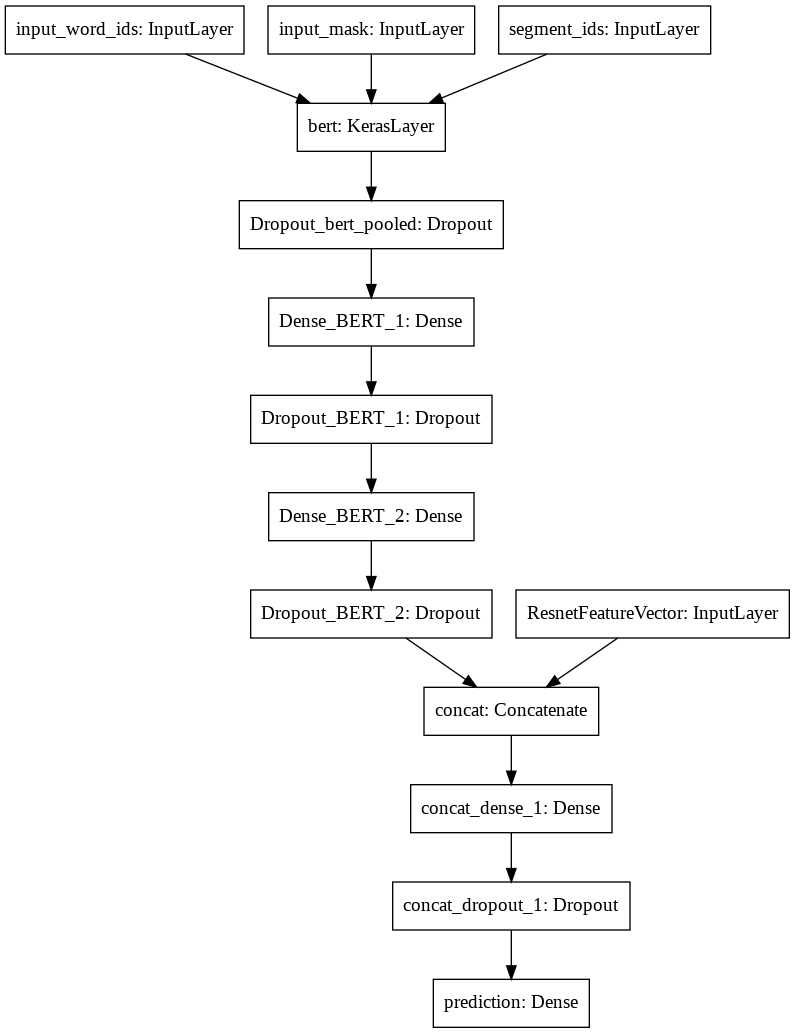

In [0]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file=plot_save_prefix + 'model_architecture.png')

In [0]:
# serialize model to JSON
model_json = model.to_json()
with open(model_save_prefix + results_prefix + '_' + str(NUM_LABELS) + '.json', "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights( model_save_prefix + results_prefix + '_' + str(NUM_LABELS) + '_weights.h5', overwrite=True)
print("Saved model to disk")

Saved model to disk


### Evaluating Results

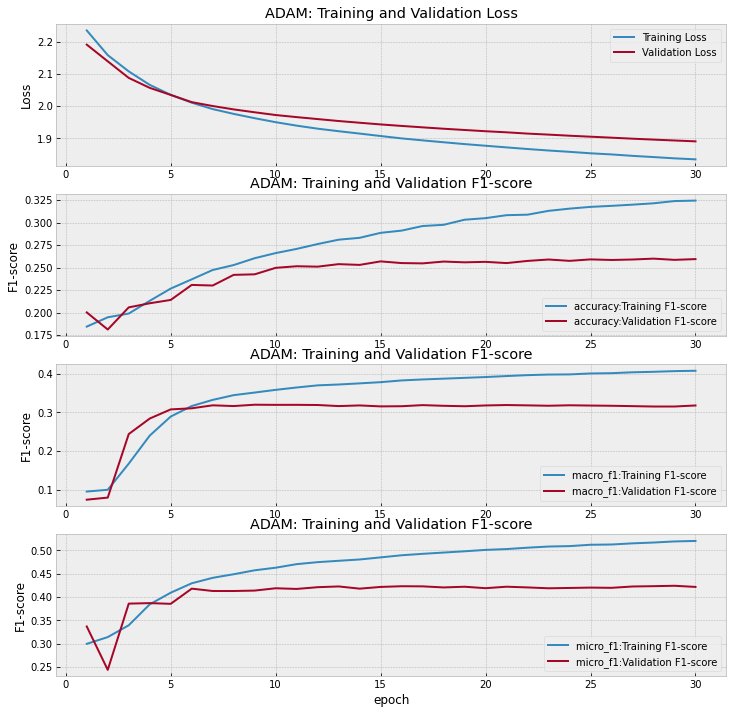

,loss,val_loss,macro_f1,micro_f1,val_macro_f1,val_micro_f1
0,2.234774,2.190738,0.184549,0.095056,0.200326,0.073980
1,2.158160,2.138979,0.194900,0.099602,0.181315,0.079394
2,2.107819,2.087574,0.199045,0.167252,0.205924,0.243812
3,2.066005,2.056702,0.213194,0.239796,0.210482,0.283966
4,2.035113,2.034844,0.226823,0.289120,0.214193,0.307662


In [0]:
import matplotlib.pyplot as plt
import matplotlib.style as style

def learning_curves(history,ACC):
    """Plot the learning curves of loss and macro f1 score 
    for the training and validation datasets.
    
    Args:
        history: history callback of fitting a tensorflow keras model 
    """
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = len(loss)
    style.use("bmh")
    num_plots = len(ACC) + 1
    plt.figure(figsize=(12, 12))

    plt.subplot(num_plots, 1, 1)
    plt.plot(range(1, epochs+1), loss, label='Training Loss')
    plt.plot(range(1, epochs+1), val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.ylabel('Loss')
    plt.title(optimizer_select + ': Training and Validation Loss')

    ctr = 2
    accuracy = []
    val_accuracy = []
    for accs in ACC:
        if isinstance(accs, str):
            acc_name = accs
        else:
            acc_name = accs.__name__
        acc_data = history.history[acc_name]
        val_acc_data = history.history['val_'+acc_name]
        accuracy.append(acc_data)
        val_accuracy.append(val_acc_data)
        plt.subplot(num_plots, 1, ctr)
        plt.plot(range(1, epochs+1), acc_data, label= acc_name + ':' + 'Training F1-score')
        plt.plot(range(1, epochs+1), val_acc_data, label = acc_name + ':' + 'Validation F1-score')
        plt.legend(loc='lower right')
        plt.ylabel('F1-score')
        plt.title(optimizer_select + ': Training and Validation F1-score')

        plt.savefig(plot_save_prefix + results_prefix + '.jpg')
        ctr+=1
    plt.xlabel('epoch')
    plt.show()
    return loss, val_loss, accuracy, val_accuracy

losses, val_losses,  accuracy, val_accuracy = learning_curves(history, ACC)
df_results = pd.DataFrame({'loss':losses,'val_loss': val_losses,
              'macro_f1':accuracy[0],'micro_f1':accuracy[1],
              'val_macro_f1':val_accuracy[0], 'val_micro_f1':val_accuracy[1]})
df_results.head()

In [0]:
df_results.to_csv(plot_save_prefix + results_prefix+ '.data', index=False)

In [0]:
'''
from tensorflow.keras.models import model_from_json

# load json and create model
with open(model_save_prefix + results_prefix  + '_' + str(NUM_LABELS) + '.json', "r") as json_file:
    loaded_model_json = json_file.read()

loaded_model = model_from_json(loaded_model_json, custom_objects = {
    'KerasLayer': hub.KerasLayer
})

# load weights into new model
loaded_model.load_weights(model_save_prefix + results_prefix  + '_' + str(NUM_LABELS) + '_weights.h5')
print("Loaded model from disk")
''' 

'\nfrom tensorflow.keras.models import model_from_json\n\n# load json and create model\nwith open(model_save_prefix + results_prefix  + \'_\' + str(NUM_LABELS) + \'.json\', "r") as json_file:\n    loaded_model_json = json_file.read()\n\nloaded_model = model_from_json(loaded_model_json, custom_objects = {\n    \'KerasLayer\': hub.KerasLayer\n})\n\n# load weights into new model\nloaded_model.load_weights(model_save_prefix + results_prefix  + \'_\' + str(NUM_LABELS) + \'_weights.h5\')\nprint("Loaded model from disk")\n'

In [0]:
def perf_grid(ds, target, label_names, model, n_thresh=100):
    """Computes the performance table containing target, label names,
    label frequencies, thresholds between 0 and 1, number of tp, fp, fn,
    precision, recall and f-score metrics for each label.
    
    Args:
        ds (tf.data.Datatset): contains the features array
        target (numpy array): target matrix of shape (BATCH_SIZE, N_LABELS)
        label_names (list of strings): column names in target matrix
        model (tensorflow keras model): model to use for prediction
        n_thresh (int) : number of thresholds to try
        
    Returns:
        grid (Pandas dataframe): performance table 
    """
    
    # Get predictions
    y_hat_val = model.predict(ds)
    # Define target matrix
    y_val = target
    # Find label frequencies in the validation set
    label_freq = target.sum(axis=0)
    # Get label indexes
    label_index = [i for i in range(len(label_names))]
    # Define thresholds
    thresholds = np.linspace(0,1,n_thresh+1).astype(np.float32)
    
    # Compute all metrics for all labels
    ids, labels, freqs, tps, fps, fns, precisions, recalls, f1s = [], [], [], [], [], [], [], [], []
    for l in label_index:
        for thresh in thresholds:   
            ids.append(l)
            labels.append(label_names[l])
            freqs.append(round(label_freq[l]/len(y_val),2))
            y_hat = y_hat_val[:,l]
            y = y_val[:,l]
            y_pred = y_hat > thresh
            tp = np.count_nonzero(y_pred  * y)
            fp = np.count_nonzero(y_pred * (1-y))
            fn = np.count_nonzero((1-y_pred) * y)
            precision = tp / (tp + fp + 1e-16)
            recall = tp / (tp + fn + 1e-16)
            f1 = 2*tp / (2*tp + fn + fp + 1e-16)
            tps.append(tp)
            fps.append(fp)
            fns.append(fn)
            precisions.append(precision)
            recalls.append(recall)
            f1s.append(f1)
            
    # Create the performance dataframe
    grid = pd.DataFrame({
        'id':ids,
        'label':labels,
        'freq':freqs,
        'threshold':list(thresholds)*len(label_index),
        'tp':tps,
        'fp':fps,
        'fn':fns,
        'precision':precisions,
        'recall':recalls,
        'f1':f1s})
    
    grid = grid[['id', 'label', 'freq', 'threshold',
                 'tp', 'fn', 'fp', 'precision', 'recall', 'f1']]
    
    return grid

In [0]:
if (ERROR_TEST):
    label_names = ['Drama']
else:
    label_names = ['Drama','Thriller','Comedy','Action','Crime',
                   'Horror','Romance','Adventure','Mystery','Sci-Fi']

In [0]:
n_thresh = 20
# cluster_resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
# tf.config.experimental_connect_to_cluster(cluster_resolver)
# tf.tpu.experimental.initialize_tpu_system(cluster_resolver)
# strategy = tf.distribute.experimental.TPUStrategy(cluster_resolver)
with strategy.scope():
    grid_train = perf_grid(bert_inputs_train_k, 
            labels_train_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)
    grid_dev = perf_grid(bert_inputs_dev_k, 
            labels_dev_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)
    grid_val = perf_grid(bert_inputs_val_k, 
            labels_val_k, 
            label_names, 
            model, 
            n_thresh=n_thresh)

In [0]:
import seaborn as sns

def table_scores(grid_data, threshold):
    max_perf = grid_data.loc[grid_data.threshold==threshold,:].groupby(['id', 'label', 'threshold','freq','precision','recall'])[['f1']].max().sort_values('f1', ascending=False).reset_index()
    max_perf.rename(columns={'f1':'f1score'}, inplace=True)
    max_perf.style.background_gradient(subset=['freq', 'f1score'], 
                                       cmap=sns.light_palette("lightgreen", as_cmap=True))
    return(max_perf)

table_scores(grid_train, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_train.f1score')
table_scores(grid_dev, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_dev.f1score')
table_scores(grid_val, threshold=0.5).to_csv(plot_save_prefix + results_prefix + '_val.f1score')
print(table_scores(grid_train, threshold=0.5))
print(table_scores(grid_dev, threshold=0.5))
print(table_scores(grid_val, threshold=0.5))


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.759773  0.707547  0.732731
1   2     Comedy        0.5  0.34   0.603493  0.559116  0.580458
2   1   Thriller        0.5  0.20   0.487950  0.526560  0.506520
3   6    Romance        0.5  0.20   0.452450  0.531521  0.488808
4   3     Action        0.5  0.15   0.389728  0.507703  0.440961
5   5     Horror        0.5  0.12   0.343698  0.567016  0.427977
6   4      Crime        0.5  0.13   0.323987  0.462861  0.381169
7   8    Mystery        0.5  0.07   0.221915  0.519847  0.311049
8   7  Adventure        0.5  0.09   0.200456  0.405189  0.268218
9   9     Sci-Fi        0.5  0.06   0.000000  0.000000  0.000000
   id      label  threshold  freq  precision    recall   f1score
0   0      Drama        0.5  0.55   0.661449  0.631412  0.646082
1   2     Comedy        0.5  0.35   0.446947  0.440308  0.443603
2   6    Romance        0.5  0.20   0.361696  0.415618  0.386787
3   1   Thriller        0

In [0]:
plot_save_prefix + results_prefix

'/content/drive/My Drive/w266-FinalProject/MoviePlotsAndPosters/plots/baseline/baseline_seqlen_128_ADAM_EPOCHS_30_LR_0.0001_LOSS_macro_double_soft_f1_NoOS'